# Text-to-Motion Retrieval — v19
**Basé sur v18.** Objectif : faire baisser la loss train ET val vers 0 sans overfit.

### Diagnostic v18 → Actions v19
| | v18 | v19 (cible) |
|---|---|---|
| Architecture motion | LSTM 128 bidir | **Transformer Encoder 3 couches** |
| TextProjection | LN+Linear | **LN→Lin→GELU→Drop→Lin** |
| Température | fixe 0.07 | **apprise (nn.Parameter)** |
| EMBED_DIM | 256 | **512** |
| Train loss finale | ~3.7 | cible <1.5 |
| Score val | 0.630 | cible >0.75 |

### Pourquoi le Transformer bat le LSTM ici
Les interactions humaines ont des dépendances longue portée (début→fin du geste).
Le LSTM les capture séquentiellement avec un goulot d'étranglement (hidden state).
Le Transformer Encoder avec self-attention accède directement à toutes les frames.

### Température apprise
`log_tau = nn.Parameter` → `tau = exp(log_tau).clamp(0.01, 0.5)`.
La température optimale varie selon la géométrie de l'espace appris : la laisser
libre permet au modèle de se concentrer sur les négatifs les plus informatifs.


## 0. Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import random, math
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split
from transformers import CLIPTextModel, CLIPTokenizer
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device : {device}')


/home/guill/Challenge Data/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device : cuda


## 1. Constantes

In [2]:
DATA_DIR   = Path('data/data')
MOTION_DIR = DATA_DIR / 'motions'
TEXT_DIR   = DATA_DIR / 'texts'
TEST_DIR   = DATA_DIR / 'test'

MAX_SEQ_LEN      = 150
BATCH_SIZE       = 512
EMBED_DIM        = 512   # ← augmenté (256→512)
DROPOUT          = 0.15  # ← léger (évite under/overfit)
TEMPERATURE_INIT = 0.07  # température initiale (sera apprise)
# Transformer motion encoder
TRANS_D_MODEL    = 256   # dim interne du transformer
TRANS_NHEAD      = 8
TRANS_LAYERS     = 3
TRANS_DIM_FF     = 512
NUM_EPOCHS       = 120
WARMUP           = 5
PATIENCE         = 20
K_VALUES         = tuple(range(1, 11))


## 2. Exploration

In [3]:
motion_files = sorted(MOTION_DIR.glob('*.npy'))
sample_m     = np.load(motion_files[0])
print(f'Motions train : {len(motion_files)},  shape ex : {sample_m.shape}')

test_subdirs = sorted([d for d in TEST_DIR.iterdir() if d.is_dir()], key=lambda d: int(d.name))
print(f'Test : {len(test_subdirs)} requêtes, {len(sorted(test_subdirs[0].glob("*.npy")))} candidats/requête')


Motions train : 6018,  shape ex : (94, 384)
Test : 30 requêtes, 32 candidats/requête


## 3. Parsing

In [4]:
def parse_train_texts(text_dir):
    txt_files    = sorted(Path(text_dir).glob('*.txt'))
    motion_texts = defaultdict(list)
    for tf in txt_files:
        lines = [l.strip() for l in tf.read_text('utf-8').splitlines() if l.strip()]
        parts = tf.stem.rsplit('_', 1)
        if len(parts) == 2 and parts[1].isdigit():
            motion_texts[parts[0]].append(lines[0] if lines else '')
        else:
            motion_texts[tf.stem] = lines
    n = [len(v) for v in motion_texts.values()]
    print(f'Motions : {len(motion_texts)}, descriptions : min={min(n)}, max={max(n)}, moy={sum(n)/len(n):.1f}')
    return dict(motion_texts)

motion_texts = parse_train_texts(TEXT_DIR)


Motions : 6018, descriptions : min=3, max=3, moy=3.0


## 4. Split

In [5]:
available_ids = [mf.stem for mf in sorted(MOTION_DIR.glob('*.npy')) if mf.stem in motion_texts]
train_ids, val_ids = train_test_split(available_ids, test_size=0.20, random_state=SEED, shuffle=True)
print(f'Train : {len(train_ids)} motions  |  Val : {len(val_ids)} motions')


Train : 4814 motions  |  Val : 1204 motions


## 5. Dataset

### Changement clé : 1 description aléatoire par motion par epoch

En v3 : 3 paires fixes → à chaque epoch le modèle voit exactement les mêmes textes.  
En v17 : on stocke les 3 descriptions et on en tire **une au hasard** dans `__getitem__`.  
→ Le texte change à chaque epoch → impossible à mémoriser → overfitting supprimé côté texte.

### Augmentation motion
- Bruit gaussien léger (σ=0.01) sur les features
- Temporal masking : on masque aléatoirement des blocs de frames  
  (même principe que SpecAugment en audio)


In [6]:
# ════════════════════════════════════════════════════════════════════════════════
# CLIP PRÉ-EXTRAIT — la clé pour le batch 512
# CLIP tourne une seule fois sur tous les textes train+val, les embeddings
# sont stockés en RAM. À chaque epoch, le Dataset retourne directement
# l'embedding pré-calculé → pas de forward CLIP dans la boucle d'entraînement
# → VRAM quasi-vide → batch 512 sans OOM.
# ════════════════════════════════════════════════════════════════════════════════

print('Chargement CLIP pour pré-extraction...')
_clip_model     = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32').to(device)
_clip_tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
_clip_model.eval()
for p in _clip_model.parameters():
    p.requires_grad = False

@torch.no_grad()
def _extract_clip(texts, bs=256):
    out = []
    for i in range(0, len(texts), bs):
        tok = _clip_tokenizer(texts[i:i+bs], padding=True, truncation=True,
                              max_length=77, return_tensors='pt').to(device)
        out.append(_clip_model(**tok).pooler_output.cpu())
    return torch.cat(out)   # (N, 512)

def preprocess_motion(motion, max_len):
    if motion.ndim == 3:
        motion = motion.reshape(motion.shape[0], -1)
    T, F = motion.shape
    if T > max_len:   motion = motion[:max_len]
    elif T < max_len: motion = np.concatenate([motion, np.zeros((max_len-T, F), np.float32)])
    return motion.astype(np.float32)

def augment_motion(motion, max_len):
    if motion.ndim == 3:
        motion = motion.reshape(motion.shape[0], -1)
    T_orig, F = motion.shape
    # Speed perturbation (nouveau)
    if random.random() > 0.3:
        real_T = next((i+1 for i in range(T_orig-1,-1,-1) if motion[i].any()), T_orig)
        if real_T >= 4:
            speed  = random.uniform(0.8, 1.2)
            new_T  = max(4, int(real_T / speed))
            old_t  = np.linspace(0, real_T-1, real_T)
            new_t  = np.linspace(0, real_T-1, new_T)
            motion = np.stack([np.interp(new_t, old_t, motion[:real_T, f])
                               for f in range(F)], axis=1).astype(np.float32)
    # Bruit gaussien
    motion = motion + np.random.randn(*motion.shape).astype(np.float32) * 0.01
    # Temporal masking
    if motion.shape[0] >= 10 and random.random() > 0.3:
        blk = max(1, int(motion.shape[0] * 0.10))
        s   = random.randint(0, motion.shape[0] - blk)
        motion[s:s+blk] = 0.0
    # Pad/tronque
    T, F = motion.shape
    if T > max_len:   motion = motion[:max_len]
    elif T < max_len: motion = np.concatenate([motion, np.zeros((max_len-T, F), np.float32)])
    return motion.astype(np.float32)


# ── Construire les paires et pré-extraire tous les embeddings CLIP ─────────────
def build_samples(motion_ids, motion_texts, motion_dir):
    """Retourne (samples, all_descs) où samples = [(path, desc_indices, mid)]."""
    samples, all_descs = [], []
    for mid in motion_ids:
        path  = Path(motion_dir) / f'{mid}.npy'
        descs = motion_texts.get(mid, [])
        if path.exists() and descs:
            start = len(all_descs)
            all_descs.extend(descs)
            samples.append((path, list(range(start, start+len(descs))), mid))
    return samples, all_descs

train_samples, train_descs = build_samples(train_ids, motion_texts, MOTION_DIR)
val_samples,   val_descs   = build_samples(val_ids,   motion_texts, MOTION_DIR)

print(f'Extraction CLIP train ({len(train_descs)} textes)...', end=' ', flush=True)
train_clip_embs = _extract_clip(train_descs)
print(train_clip_embs.shape)

print(f'Extraction CLIP val   ({len(val_descs)} textes)...', end=' ', flush=True)
val_clip_embs = _extract_clip(val_descs)
print(val_clip_embs.shape)

del _clip_model
torch.cuda.empty_cache()
print('CLIP libéré de la VRAM — embeddings conservés en RAM.')

MOTION_DIM = int(np.load(train_samples[0][0]).reshape(
    np.load(train_samples[0][0]).shape[0], -1).shape[1])
print(f'Motion dim : {MOTION_DIM}')


class PreExtractedDataset(Dataset):
    """
    Un sample = une motion.
    __getitem__ tire aléatoirement une des 3 descriptions (comme v17)
    mais retourne son embedding CLIP pré-calculé au lieu de tokeniser.
    """
    def __init__(self, samples, clip_embs, max_seq_len=150, augment=False):
        self.samples     = samples    # [(path, [desc_indices], mid)]
        self.clip_embs   = clip_embs  # tensor (N_descs_total, 512)
        self.max_seq_len = max_seq_len
        self.augment     = augment

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, desc_indices, mid = self.samples[idx]
        # Tirer un embedding CLIP au hasard parmi les 3 descriptions
        emb_idx  = random.choice(desc_indices)
        clip_emb = self.clip_embs[emb_idx]
        motion   = np.load(path)
        motion   = augment_motion(motion, self.max_seq_len) if self.augment                    else preprocess_motion(motion, self.max_seq_len)
        return {'clip_emb': clip_emb,
                'motion':   torch.from_numpy(motion),
                'motion_id': mid}

def collate_fn(batch):
    return {'clip_emb':  torch.stack([b['clip_emb']  for b in batch]),
            'motion':    torch.stack([b['motion']     for b in batch]),
            'motion_id': [b['motion_id'] for b in batch]}

train_dataset = PreExtractedDataset(train_samples, train_clip_embs, MAX_SEQ_LEN, augment=True)
val_dataset   = PreExtractedDataset(val_samples,   val_clip_embs,   MAX_SEQ_LEN, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True, collate_fn=collate_fn, drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True, collate_fn=collate_fn)

# TestDataset reste identique (pas de CLIP pré-extrait, rechargé à l'inférence)
print(f'Train : {len(train_dataset)} motions, {len(train_loader)} batches de {BATCH_SIZE}')
print(f'Val   : {len(val_dataset)} motions,  {len(val_loader)} batches')


Chargement CLIP pour pré-extraction...


Loading weights: 100%|██████████| 196/196 [00:00<00:00, 990.89it/s, Materializing param=text_model.final_layer_norm.weight]                    
CLIPTextModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                                            | Status     |  | 
---------------------------------------------------------------+------------+--+-
vision_model.encoder.layers.{0...11}.mlp.fc2.bias              | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.layer_norm2.weight        | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.layer_norm1.bias          | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.self_attn.v_proj.weight   | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.self_attn.k_proj.weight   | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.self_attn.q_proj.weight   | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.mlp.fc1.weight            | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.mlp.fc1.bias        

Extraction CLIP train (14442 textes)... torch.Size([14442, 512])
Extraction CLIP val   (3612 textes)... torch.Size([3612, 512])
CLIP libéré de la VRAM — embeddings conservés en RAM.
Motion dim : 384
Train : 4814 motions, 9 batches de 512
Val   : 1204 motions,  3 batches


## 6. Modèle — Transformer Encoder + température apprise

| Composant | v18 | v19 |
|---|---|---|
| Motion encoder | LSTM 128 bidir | **Transformer 3L × 8H** |
| TextProjection | LN+Lin(512→256) | **LN→Lin(512→512)→GELU→Drop→Lin(512→512)** |
| Température | fixe 0.07 | **nn.Parameter (apprise)** |
| EMBED_DIM | 256 | **512** |


In [7]:
import math

# ─── Encodage positionnel sinusoïdal ─────────────────────────────────────────
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, dropout=0.1):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        pe  = torch.zeros(max_len, d_model)
        pos = torch.arange(max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        return self.drop(x + self.pe[:, :x.size(1)])


# ─── Motion Encoder — Transformer ────────────────────────────────────────────
class MotionEncoder(nn.Module):
    """
    Projette la motion (T, MOTION_DIM) → embedding (EMBED_DIM,) via :
      1. Linear(MOTION_DIM → TRANS_D_MODEL)
      2. PositionalEncoding
      3. TransformerEncoder (TRANS_LAYERS couches, TRANS_NHEAD têtes)
      4. Moyenne temporelle (mean pooling)
      5. Linear(TRANS_D_MODEL → EMBED_DIM)
    """
    def __init__(self, input_dim=None, d_model=TRANS_D_MODEL, nhead=TRANS_NHEAD,
                 num_layers=TRANS_LAYERS, dim_ff=TRANS_DIM_FF,
                 embed_dim=EMBED_DIM, dropout=DROPOUT):
        super().__init__()
        in_dim = input_dim if input_dim is not None else MOTION_DIM
        self.input_proj = nn.Sequential(
            nn.Linear(in_dim, d_model),
            nn.LayerNorm(d_model),
        )
        self.pos_enc = PositionalEncoding(d_model, dropout=dropout)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_ff,
            dropout=dropout, batch_first=True, norm_first=True,  # Pre-LN plus stable
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.out_proj = nn.Sequential(
            nn.Linear(d_model, embed_dim),
        )

    def forward(self, x):
        # x : (B, T, MOTION_DIM)
        x = self.input_proj(x)         # (B, T, d_model)
        x = self.pos_enc(x)
        x = self.transformer(x)        # (B, T, d_model)
        x = x.mean(dim=1)             # (B, d_model)  — mean pooling
        return F.normalize(self.out_proj(x), dim=-1)  # (B, embed_dim)


# ─── Text Projection ─────────────────────────────────────────────────────────
class TextProjection(nn.Module):
    """Projette les embeddings CLIP (512) vers EMBED_DIM via un MLP 2-couches."""
    def __init__(self, clip_dim=512, embed_dim=EMBED_DIM, dropout=DROPOUT):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(clip_dim),
            nn.Linear(clip_dim, embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, embed_dim),
        )

    def forward(self, x):
        return F.normalize(self.net(x), dim=-1)


# ─── InfoNCE avec température apprise ────────────────────────────────────────
class InfoNCELoss(nn.Module):
    """
    Température apprise : log_tau est un paramètre, tau = exp(log_tau).
    Clampée dans [0.01, 0.5] pour la stabilité.
    """
    def __init__(self, init_temp=TEMPERATURE_INIT):
        super().__init__()
        self.log_tau = nn.Parameter(torch.tensor(math.log(init_temp)))

    @property
    def temperature(self):
        return self.log_tau.exp().clamp(0.01, 0.5)

    def forward(self, t, m):
        N      = len(t)
        labels = torch.arange(N, device=t.device)
        tau    = self.temperature
        logits = (t @ m.T) / tau
        return (F.cross_entropy(logits, labels) +
                F.cross_entropy(logits.T, labels)) / 2


# ─── Modèle complet ───────────────────────────────────────────────────────────
class TextMotionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.text_proj  = TextProjection()
        self.motion_enc = MotionEncoder()
        self.loss_fn    = InfoNCELoss()

    def forward(self, clip_embs, motions):
        t = self.text_proj(clip_embs)
        m = self.motion_enc(motions)
        return self.loss_fn(t, m), t, m

    def encode_clip(self, clip_embs):   return self.text_proj(clip_embs)
    def encode_motion(self, motions):   return self.motion_enc(motions)


model = TextMotionModel().to(device)

total     = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Paramètres totaux      : {total:,}')
print(f'Paramètres entraîn.    : {trainable:,}')
print(f'  TextProjection       : {sum(p.numel() for p in model.text_proj.parameters()):,}')
print(f'  MotionEncoder        : {sum(p.numel() for p in model.motion_enc.parameters()):,}')
print(f'  InfoNCE log_tau      : {model.loss_fn.log_tau.item():.4f}  '
      f'(tau={model.loss_fn.temperature.item():.4f})')


Paramètres totaux      : 2,338,305
Paramètres entraîn.    : 2,338,305
  TextProjection       : 526,336
  MotionEncoder        : 1,811,968
  InfoNCE log_tau      : -2.6593  (tau=0.0700)


/tmp/ipykernel_94822/3342974056.py:43: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.transformer = nn.TransformerEncoder(enc_layer, num_layers=num_layers)


## 7. Métriques

In [8]:
def kaggle_score(recalls):
    ks = sorted(recalls.keys())
    return sum(recalls[k] / k for k in ks) / sum(1.0 / k for k in ks)


@torch.no_grad()
def compute_val_metrics(model, val_loader, device,
                        k_values=K_VALUES, n_distractors=31, n_trials=5):
    model.eval()
    all_t, all_m, all_mids = [], [], []
    total_val_loss = 0.0
    tau = model.loss_fn.temperature.item()

    for batch in val_loader:
        t = model.encode_clip(batch['clip_emb'].to(device)).cpu()
        m = model.encode_motion(batch['motion'].to(device)).cpu()
        all_t.append(t); all_m.append(m)
        all_mids.extend(batch['motion_id'])

        logits = (t.to(device) @ m.to(device).T) / tau
        labels = torch.arange(len(t), device=device)
        loss   = (F.cross_entropy(logits, labels) +
                  F.cross_entropy(logits.T, labels)) / 2
        total_val_loss += loss.item()

    T   = torch.cat(all_t)
    M   = torch.cat(all_m)
    N   = len(T)
    avg_val_loss = total_val_loss / len(val_loader)

    mid_to_idx = defaultdict(list)
    for idx, mid in enumerate(all_mids):
        mid_to_idx[mid].append(idx)

    recalls = {k: 0.0 for k in k_values}
    for _ in range(n_trials):
        for i in range(N):
            correct_idxs = set(mid_to_idx[all_mids[i]])
            distractors  = [j for j in range(N) if j not in correct_idxs]
            pool         = list(correct_idxs) + random.sample(
                               distractors, min(n_distractors, len(distractors)))
            sims   = (T[i].unsqueeze(0) @ M[pool].T).squeeze(0)
            ranked = torch.argsort(sims, descending=True).tolist()
            correct_pool = set(range(len(correct_idxs)))
            for k in k_values:
                if any(r in correct_pool for r in ranked[:k]):
                    recalls[k] += 1.0

    recalls = {k: v / (N * n_trials) for k, v in recalls.items()}
    return avg_val_loss, recalls, kaggle_score(recalls)


print('Métriques OK.')


Métriques OK.


## 8. Entraînement — warmup + cosine + early stopping

In [9]:
# Groupes de paramètres séparés — tau a un LR plus faible
optimizer = torch.optim.AdamW([
    {'params': model.text_proj.parameters(),  'lr': 3e-4, 'weight_decay': 0.05},
    {'params': model.motion_enc.parameters(), 'lr': 3e-4, 'weight_decay': 0.05},
    {'params': [model.loss_fn.log_tau],        'lr': 1e-3, 'weight_decay': 0.0},
])

def lr_lambda(epoch):
    if epoch < WARMUP:
        return (epoch + 1) / WARMUP
    progress = (epoch - WARMUP) / max(1, NUM_EPOCHS - WARMUP)
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler  = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
best_score = 0.0
no_improve = 0
history    = []

for epoch in range(1, NUM_EPOCHS + 1):

    # ── Train ─────────────────────────────────────────────────────────────────
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch:3d}/{NUM_EPOCHS}', leave=False)
    for batch in pbar:
        optimizer.zero_grad()
        loss, _, _ = model(batch['clip_emb'].to(device), batch['motion'].to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix(loss=f'{loss.item():.4f}',
                         tau=f'{model.loss_fn.temperature.item():.4f}')
    avg_loss = total_loss / len(train_loader)
    scheduler.step()

    # ── Val ───────────────────────────────────────────────────────────────────
    avg_val, val_r, score = compute_val_metrics(model, val_loader, device)
    r1, r5, r10 = val_r[1], val_r[5], val_r[10]
    lr_cur = optimizer.param_groups[1]['lr']
    tau    = model.loss_fn.temperature.item()

    print(f'Epoch {epoch:3d} | train {avg_loss:.4f}  val {avg_val:.4f} | '
          f'R@1 {r1:.4f}  R@5 {r5:.4f}  R@10 {r10:.4f} | '
          f'Score {score:.4f} | tau {tau:.4f} | lr {lr_cur:.2e}')

    history.append({'epoch': epoch, 'train_loss': avg_loss, 'val_loss': avg_val,
                    'R@1': r1, 'R@5': r5, 'R@10': r10, 'score': score, 'tau': tau})

    if score > best_score:
        best_score = score
        no_improve = 0
        torch.save(model.state_dict(), 'best_model_v19.pt')
        print(f'  -> Meilleur score sauvegardé (Score={score:.4f}, tau={tau:.4f})')
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f'  -> Early stopping ({PATIENCE} epochs sans amélioration)')
            break

    if epoch % 20 == 0:
        torch.save(model.state_dict(), f'checkpoint_v19_epoch_{epoch}.pt')

print(f'\nMeilleur Score Kaggle val : {best_score:.4f}')


Epoch   1 | train 6.1335  val 5.6725 | R@1 0.0772  R@5 0.3198  R@10 0.5547 | Score 0.2185 | tau 0.0701 | lr 1.20e-04
  -> Meilleur score sauvegardé (Score=0.2185, tau=0.0701)


Epoch   2 | train 5.9354  val 5.5175 | R@1 0.1244  R@5 0.4304  R@10 0.6586 | Score 0.2988 | tau 0.0700 | lr 1.80e-04
  -> Meilleur score sauvegardé (Score=0.2988, tau=0.0700)


Epoch   3 | train 5.7462  val 5.2731 | R@1 0.1585  R@5 0.5193  R@10 0.7387 | Score 0.3627 | tau 0.0698 | lr 2.40e-04
  -> Meilleur score sauvegardé (Score=0.3627, tau=0.0698)


Epoch   4 | train 5.5053  val 5.0531 | R@1 0.2106  R@5 0.5934  R@10 0.8131 | Score 0.4278 | tau 0.0694 | lr 3.00e-04
  -> Meilleur score sauvegardé (Score=0.4278, tau=0.0694)


Epoch   5 | train 5.2914  val 4.8949 | R@1 0.2477  R@5 0.6399  R@10 0.8390 | Score 0.4694 | tau 0.0692 | lr 3.00e-04
  -> Meilleur score sauvegardé (Score=0.4694, tau=0.0692)


Epoch   6 | train 5.0992  val 4.6968 | R@1 0.2842  R@5 0.6997  R@10 0.8741 | Score 0.5168 | tau 0.0688 | lr 3.00e-04
  -> Meilleur score sauvegardé (Score=0.5168, tau=0.0688)


Epoch   7 | train 4.9483  val 4.5939 | R@1 0.3047  R@5 0.7259  R@10 0.8884 | Score 0.5419 | tau 0.0684 | lr 3.00e-04
  -> Meilleur score sauvegardé (Score=0.5419, tau=0.0684)


Epoch   8 | train 4.8060  val 4.5109 | R@1 0.3229  R@5 0.7415  R@10 0.8937 | Score 0.5562 | tau 0.0678 | lr 2.99e-04
  -> Meilleur score sauvegardé (Score=0.5562, tau=0.0678)


Epoch   9 | train 4.6814  val 4.4299 | R@1 0.3553  R@5 0.7641  R@10 0.9116 | Score 0.5852 | tau 0.0672 | lr 2.99e-04
  -> Meilleur score sauvegardé (Score=0.5852, tau=0.0672)


Epoch  10 | train 4.5609  val 4.3236 | R@1 0.3640  R@5 0.7882  R@10 0.9189 | Score 0.5996 | tau 0.0665 | lr 2.99e-04
  -> Meilleur score sauvegardé (Score=0.5996, tau=0.0665)


Epoch  11 | train 4.4516  val 4.3156 | R@1 0.3738  R@5 0.7920  R@10 0.9214 | Score 0.6077 | tau 0.0658 | lr 2.98e-04
  -> Meilleur score sauvegardé (Score=0.6077, tau=0.0658)


Epoch  12 | train 4.3756  val 4.2421 | R@1 0.3905  R@5 0.8061  R@10 0.9274 | Score 0.6251 | tau 0.0651 | lr 2.97e-04
  -> Meilleur score sauvegardé (Score=0.6251, tau=0.0651)


Epoch  13 | train 4.2580  val 4.2481 | R@1 0.3892  R@5 0.8075  R@10 0.9271 | Score 0.6231 | tau 0.0644 | lr 2.96e-04


Epoch  14 | train 4.1849  val 4.1495 | R@1 0.3952  R@5 0.8191  R@10 0.9409 | Score 0.6325 | tau 0.0636 | lr 2.95e-04
  -> Meilleur score sauvegardé (Score=0.6325, tau=0.0636)


Epoch  15 | train 4.0846  val 4.1867 | R@1 0.4106  R@5 0.8080  R@10 0.9301 | Score 0.6352 | tau 0.0629 | lr 2.94e-04
  -> Meilleur score sauvegardé (Score=0.6352, tau=0.0629)


Epoch  16 | train 4.0176  val 4.0865 | R@1 0.4279  R@5 0.8334  R@10 0.9329 | Score 0.6543 | tau 0.0621 | lr 2.93e-04
  -> Meilleur score sauvegardé (Score=0.6543, tau=0.0621)


Epoch  17 | train 3.9200  val 4.1250 | R@1 0.4108  R@5 0.8156  R@10 0.9331 | Score 0.6399 | tau 0.0613 | lr 2.92e-04


Epoch  18 | train 3.8236  val 4.0390 | R@1 0.4319  R@5 0.8415  R@10 0.9422 | Score 0.6612 | tau 0.0605 | lr 2.91e-04
  -> Meilleur score sauvegardé (Score=0.6612, tau=0.0605)


Epoch  19 | train 3.7572  val 4.0524 | R@1 0.4365  R@5 0.8362  R@10 0.9419 | Score 0.6595 | tau 0.0598 | lr 2.89e-04


Epoch  20 | train 3.6668  val 4.0548 | R@1 0.4243  R@5 0.8271  R@10 0.9374 | Score 0.6512 | tau 0.0590 | lr 2.88e-04


Epoch  21 | train 3.6082  val 4.0362 | R@1 0.4517  R@5 0.8322  R@10 0.9409 | Score 0.6690 | tau 0.0583 | lr 2.86e-04
  -> Meilleur score sauvegardé (Score=0.6690, tau=0.0583)


Epoch  22 | train 3.5174  val 4.0646 | R@1 0.4405  R@5 0.8372  R@10 0.9409 | Score 0.6642 | tau 0.0577 | lr 2.84e-04


Epoch  23 | train 3.4444  val 4.0471 | R@1 0.4475  R@5 0.8322  R@10 0.9342 | Score 0.6658 | tau 0.0570 | lr 2.82e-04


Epoch  24 | train 3.3895  val 3.9936 | R@1 0.4532  R@5 0.8375  R@10 0.9395 | Score 0.6713 | tau 0.0564 | lr 2.80e-04
  -> Meilleur score sauvegardé (Score=0.6713, tau=0.0564)


Epoch  25 | train 3.2750  val 3.9891 | R@1 0.4517  R@5 0.8390  R@10 0.9420 | Score 0.6725 | tau 0.0557 | lr 2.78e-04
  -> Meilleur score sauvegardé (Score=0.6725, tau=0.0557)


Epoch  26 | train 3.2315  val 3.9843 | R@1 0.4650  R@5 0.8414  R@10 0.9422 | Score 0.6786 | tau 0.0551 | lr 2.76e-04
  -> Meilleur score sauvegardé (Score=0.6786, tau=0.0551)


Epoch  27 | train 3.1506  val 3.9789 | R@1 0.4658  R@5 0.8400  R@10 0.9382 | Score 0.6785 | tau 0.0545 | lr 2.74e-04


Epoch  28 | train 3.0934  val 4.0128 | R@1 0.4666  R@5 0.8385  R@10 0.9400 | Score 0.6770 | tau 0.0540 | lr 2.71e-04


Epoch  29 | train 3.0470  val 3.9328 | R@1 0.4703  R@5 0.8510  R@10 0.9480 | Score 0.6843 | tau 0.0534 | lr 2.69e-04
  -> Meilleur score sauvegardé (Score=0.6843, tau=0.0534)


Epoch  30 | train 2.9762  val 4.0344 | R@1 0.4603  R@5 0.8424  R@10 0.9390 | Score 0.6754 | tau 0.0528 | lr 2.66e-04


Epoch  31 | train 2.8945  val 3.9923 | R@1 0.4754  R@5 0.8409  R@10 0.9387 | Score 0.6811 | tau 0.0523 | lr 2.64e-04


Epoch  32 | train 2.8299  val 4.0145 | R@1 0.4691  R@5 0.8465  R@10 0.9470 | Score 0.6837 | tau 0.0518 | lr 2.61e-04


Epoch  33 | train 2.7506  val 4.0058 | R@1 0.4645  R@5 0.8434  R@10 0.9452 | Score 0.6792 | tau 0.0513 | lr 2.58e-04


Epoch  34 | train 2.7243  val 4.0772 | R@1 0.4576  R@5 0.8344  R@10 0.9372 | Score 0.6716 | tau 0.0508 | lr 2.55e-04


Epoch  35 | train 2.6631  val 4.0419 | R@1 0.4713  R@5 0.8465  R@10 0.9385 | Score 0.6841 | tau 0.0502 | lr 2.52e-04


Epoch  36 | train 2.5808  val 4.0709 | R@1 0.4654  R@5 0.8512  R@10 0.9417 | Score 0.6812 | tau 0.0498 | lr 2.49e-04


Epoch  37 | train 2.5131  val 4.0808 | R@1 0.4691  R@5 0.8460  R@10 0.9372 | Score 0.6816 | tau 0.0493 | lr 2.46e-04


Epoch  38 | train 2.4351  val 4.0948 | R@1 0.4716  R@5 0.8452  R@10 0.9372 | Score 0.6830 | tau 0.0489 | lr 2.43e-04


Epoch  39 | train 2.4186  val 4.1232 | R@1 0.4698  R@5 0.8294  R@10 0.9327 | Score 0.6741 | tau 0.0484 | lr 2.40e-04


Epoch  40 | train 2.3571  val 4.1509 | R@1 0.4733  R@5 0.8384  R@10 0.9419 | Score 0.6799 | tau 0.0480 | lr 2.37e-04


Epoch  41 | train 2.3133  val 4.0431 | R@1 0.4739  R@5 0.8435  R@10 0.9415 | Score 0.6838 | tau 0.0476 | lr 2.33e-04


Epoch  42 | train 2.2508  val 4.0984 | R@1 0.4724  R@5 0.8327  R@10 0.9375 | Score 0.6777 | tau 0.0472 | lr 2.30e-04


Epoch  43 | train 2.2328  val 4.1260 | R@1 0.4636  R@5 0.8389  R@10 0.9422 | Score 0.6769 | tau 0.0469 | lr 2.26e-04


Epoch  44 | train 2.1528  val 4.1736 | R@1 0.4721  R@5 0.8294  R@10 0.9316 | Score 0.6756 | tau 0.0465 | lr 2.23e-04


Epoch  45 | train 2.1143  val 4.1113 | R@1 0.4792  R@5 0.8365  R@10 0.9374 | Score 0.6827 | tau 0.0461 | lr 2.19e-04


Epoch  46 | train 2.0432  val 4.1360 | R@1 0.4837  R@5 0.8350  R@10 0.9362 | Score 0.6835 | tau 0.0458 | lr 2.15e-04


Epoch  47 | train 2.0110  val 4.1888 | R@1 0.4645  R@5 0.8277  R@10 0.9392 | Score 0.6740 | tau 0.0454 | lr 2.12e-04


Epoch  48 | train 1.9623  val 4.1721 | R@1 0.4699  R@5 0.8344  R@10 0.9367 | Score 0.6773 | tau 0.0451 | lr 2.08e-04


Epoch  49 | train 1.9259  val 4.1606 | R@1 0.4767  R@5 0.8346  R@10 0.9405 | Score 0.6830 | tau 0.0447 | lr 2.04e-04
  -> Early stopping (20 epochs sans amélioration)

Meilleur Score Kaggle val : 0.6843


## 9. Courbes

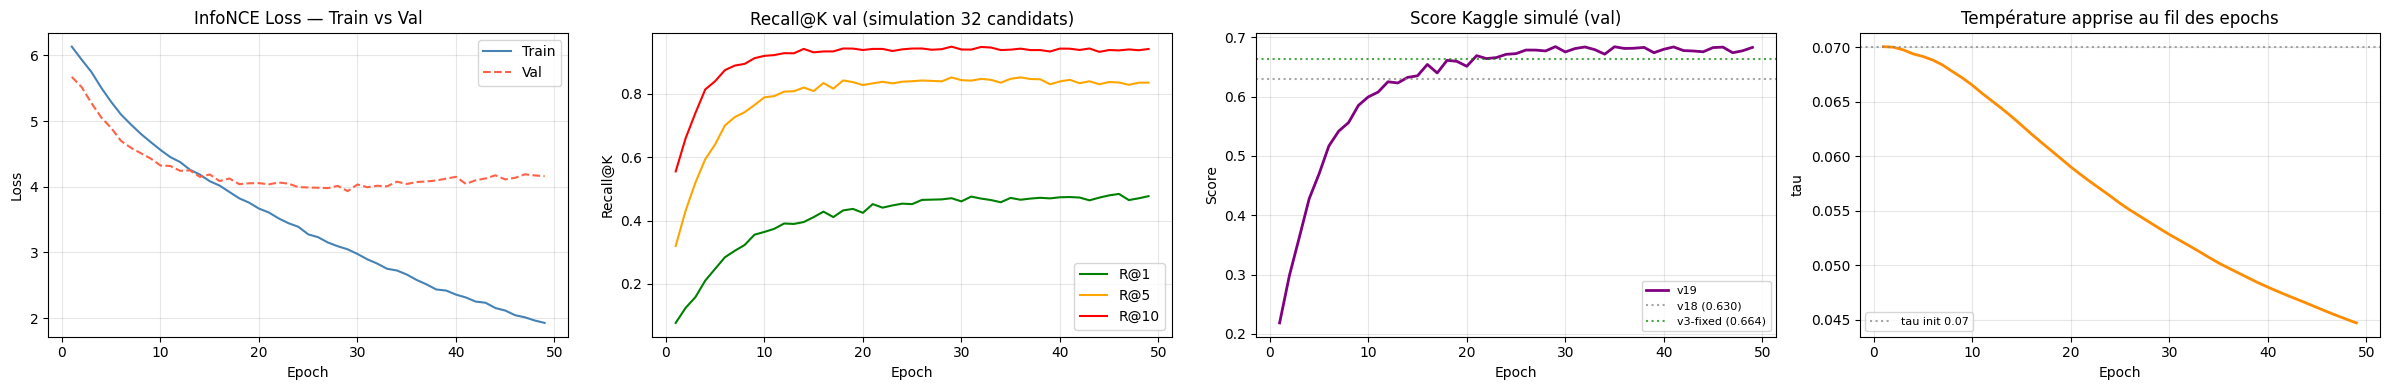

Meilleure époque : 29
  R@1=0.4703  R@5=0.8510  R@10=0.9480
  Score Kaggle simulé : 0.6843
  Température tau : 0.0534
  Gap val-train : +0.8858  (overfitting)


In [10]:
hist_df = pd.DataFrame(history)
fig, axes = plt.subplots(1, 4, figsize=(24, 4))

# ── Loss ──────────────────────────────────────────────────────────────────────
axes[0].plot(hist_df['epoch'], hist_df['train_loss'], label='Train', color='steelblue')
axes[0].plot(hist_df['epoch'], hist_df['val_loss'],   label='Val',   color='tomato', linestyle='--')
axes[0].set(xlabel='Epoch', ylabel='Loss', title='InfoNCE Loss — Train vs Val')
axes[0].legend(); axes[0].grid(alpha=0.3)

# ── Recall@K ──────────────────────────────────────────────────────────────────
for k, c in zip([1, 5, 10], ['green', 'orange', 'red']):
    axes[1].plot(hist_df['epoch'], hist_df[f'R@{k}'], label=f'R@{k}', color=c)
axes[1].set(xlabel='Epoch', ylabel='Recall@K', title='Recall@K val (simulation 32 candidats)')
axes[1].legend(); axes[1].grid(alpha=0.3)

# ── Score Kaggle ──────────────────────────────────────────────────────────────
axes[2].plot(hist_df['epoch'], hist_df['score'], color='purple', linewidth=2, label='v19')
axes[2].axhline(0.6302, color='gray',  linestyle=':', alpha=0.7, label='v18 (0.630)')
axes[2].axhline(0.6643, color='green', linestyle=':', alpha=0.7, label='v3-fixed (0.664)')
axes[2].set(xlabel='Epoch', ylabel='Score', title='Score Kaggle simulé (val)')
axes[2].legend(fontsize=8); axes[2].grid(alpha=0.3)

# ── Température apprise ───────────────────────────────────────────────────────
axes[3].plot(hist_df['epoch'], hist_df['tau'], color='darkorange', linewidth=2)
axes[3].axhline(0.07, color='gray', linestyle=':', alpha=0.7, label='tau init 0.07')
axes[3].set(xlabel='Epoch', ylabel='tau', title='Température apprise au fil des epochs')
axes[3].legend(fontsize=8); axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_v19.png', dpi=150)
plt.show()

best = hist_df.loc[hist_df['score'].idxmax()]
print(f"Meilleure époque : {int(best['epoch'])}")
print(f"  R@1={best['R@1']:.4f}  R@5={best['R@5']:.4f}  R@10={best['R@10']:.4f}")
print(f"  Score Kaggle simulé : {best['score']:.4f}")
print(f"  Température tau : {best['tau']:.4f}")
gap = best['val_loss'] - best['train_loss']
print(f"  Gap val-train : {gap:+.4f}  ({'OK' if abs(gap) < 0.8 else 'overfitting' if gap > 0 else 'underfitting'})")


## 10. Matrice de similarité cosinus (Text × Motion)

Visualise les similarités cosinus entre embeddings texte et motion sur un sous-ensemble de la validation.
La **diagonale** doit être la plus chaude (paires correctes). Les hors-diagonale doivent être froides.
Une diagonale nette = bon alignement cross-modal.

Similarité diagonale  (paires correctes) : moy=0.3177  
Similarité hors-diag (paires incorrectes): moy=0.0154
Gap diagonal - hors-diag : 0.3022


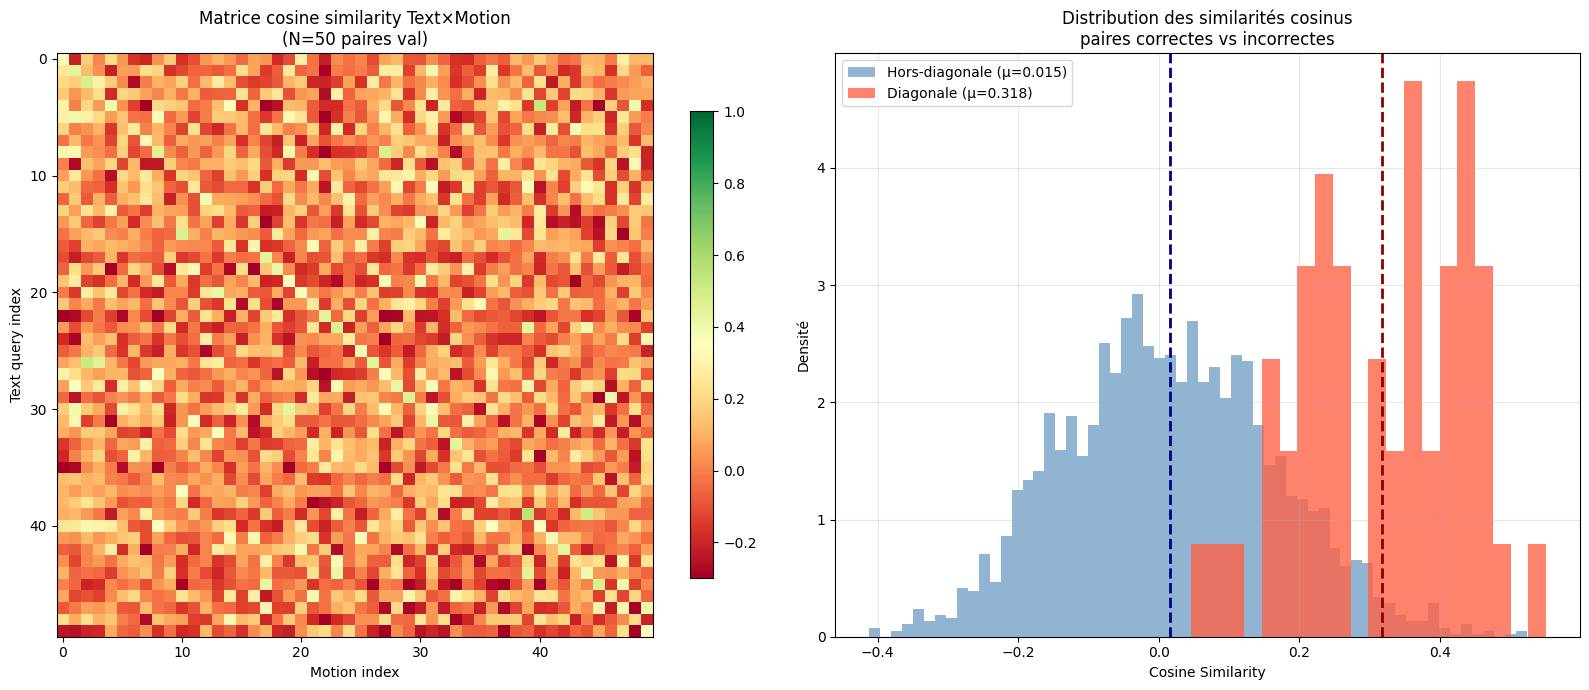


Rang médian de la bonne motion : 2.0 / 50
% de R@1 sur ce sous-ensemble  : 0.400


In [11]:
model.load_state_dict(torch.load('best_model_v19.pt', map_location=device))
model.eval()

N_DISPLAY = 50   # nombre de paires à visualiser

# ── Collecte des embeddings sur un sous-ensemble val ─────────────────────────
text_embs_list, motion_embs_list, label_list = [], [], []

with torch.no_grad():
    for batch in val_loader:
        t = model.encode_clip(batch['clip_emb'].to(device)).cpu()
        m = model.encode_motion(batch['motion'].to(device)).cpu()
        text_embs_list.append(t)
        motion_embs_list.append(m)
        label_list.extend(batch['motion_id'])
        if sum(len(x) for x in text_embs_list) >= N_DISPLAY:
            break

T_emb = torch.cat(text_embs_list)[:N_DISPLAY]   # (N, EMBED_DIM)
M_emb = torch.cat(motion_embs_list)[:N_DISPLAY]  # (N, EMBED_DIM)

# ── Matrice de similarité cosinus N×N ─────────────────────────────────────────
# T_emb et M_emb sont déjà normalisés L2 → produit scalaire = cosine similarity
sim_matrix = (T_emb @ M_emb.T).numpy()   # (N, N)

# ── Statistiques ──────────────────────────────────────────────────────────────
diag_vals     = np.diag(sim_matrix)
off_diag_vals = sim_matrix[~np.eye(N_DISPLAY, dtype=bool)]
print(f'Similarité diagonale  (paires correctes) : moy={diag_vals.mean():.4f}  ')
print(f'Similarité hors-diag (paires incorrectes): moy={off_diag_vals.mean():.4f}')
print(f'Gap diagonal - hors-diag : {diag_vals.mean() - off_diag_vals.mean():.4f}')

# ── Visualisation ─────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Heatmap complète
im = axes[0].imshow(sim_matrix, cmap='RdYlGn', vmin=-0.3, vmax=1.0, aspect='auto')
axes[0].set_title(f'Matrice cosine similarity Text×Motion\n'
                   f'(N={N_DISPLAY} paires val)', fontsize=12)
axes[0].set_xlabel('Motion index'); axes[0].set_ylabel('Text query index')
plt.colorbar(im, ax=axes[0], shrink=0.8)

# Histogramme diagonal vs hors-diagonale
axes[1].hist(off_diag_vals, bins=60, alpha=0.6, color='steelblue',
             label=f'Hors-diagonale (μ={off_diag_vals.mean():.3f})', density=True)
axes[1].hist(diag_vals,     bins=20, alpha=0.8, color='tomato',
             label=f'Diagonale (μ={diag_vals.mean():.3f})', density=True)
axes[1].axvline(diag_vals.mean(),     color='darkred',   linestyle='--', linewidth=2)
axes[1].axvline(off_diag_vals.mean(), color='navy',      linestyle='--', linewidth=2)
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Densité')
axes[1].set_title('Distribution des similarités cosinus\npaires correctes vs incorrectes')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('cosine_similarity_matrix_v19.png', dpi=150)
plt.show()

# ── Rang médian de la bonne paire ─────────────────────────────────────────────
ranks = []
for i in range(N_DISPLAY):
    row    = sim_matrix[i]
    rank   = np.sum(row > row[i]) + 1   # rang 1 = meilleur
    ranks.append(rank)
print(f'\nRang médian de la bonne motion : {np.median(ranks):.1f} / {N_DISPLAY}')
print(f'% de R@1 sur ce sous-ensemble  : {sum(r==1 for r in ranks)/N_DISPLAY:.3f}')


## 10. Submission

In [ ]:
model.load_state_dict(torch.load('best_model_v19.pt', map_location=device))
model.eval()
print('Meilleur modèle v18 chargé.')

# Recharger CLIP pour l'inférence (encode les requêtes texte du test)
print('Rechargement CLIP pour inférence...')
_clip_inf   = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32').to(device)
_clip_tok   = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
_clip_inf.eval()
for p in _clip_inf.parameters():
    p.requires_grad = False

@torch.no_grad()
def encode_text_query(text):
    tok = _clip_tok([text], padding=True, truncation=True,
                    max_length=77, return_tensors='pt').to(device)
    emb = _clip_inf(**tok).pooler_output
    return model.encode_clip(emb)


In [ ]:
errors = 0
for _, row in submission_df.iterrows():
    cands = row[[f'candidate_{k}' for k in range(1, TOP_K+1)]].dropna().tolist()
    if len(cands) != len(set(cands)): print(f'[!] Doublon query_id={row["query_id"]}'); errors += 1
    if len(cands) != TOP_K:           print(f'[!] {len(cands)}/{TOP_K}'); errors += 1
if errors == 0:
    print(f'Soumission valide : {len(submission_df)} requêtes, {TOP_K} candidats, 0 doublon.')
